In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-churn-dataset-modified-to-nigerian/Customer_Churn_Data.csv


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
# Load data
df = pd.read_csv("/kaggle/input/customer-churn-dataset-modified-to-nigerian/Customer_Churn_Data.csv")
df.head()

,RowNumber,CustomerId,CreditScore,Location,Gender,Age,Tenure,Balance,NumOfProducts,HasDbCard,IsActiveMember,EstimatedSalary,SMSEmailAlert,Exited
0,1,15634602,619,Lagos,Female,42,2,0.00,1,1,1,101348.88,0,1
1,2,15647311,608,Abuja,Female,41,1,83807.86,1,0,1,112542.58,1,0
2,3,15619304,502,Lagos,Female,42,8,159660.80,3,1,0,113931.57,0,1
3,4,15701354,699,Lagos,Female,39,1,0.00,2,0,0,93826.63,1,0
4,5,15737888,850,Abuja,Female,43,2,125510.82,1,1,1,79084.10,1,0


In [4]:
df.shape

(10000, 14)

In [5]:
# Drop identifiers only
df.drop(['RowNumber', 'CustomerId'], axis=1, inplace=True)
df.head()

,CreditScore,Location,Gender,Age,Tenure,Balance,NumOfProducts,HasDbCard,IsActiveMember,EstimatedSalary,SMSEmailAlert,Exited
0,619,Lagos,Female,42,2,0.00,1,1,1,101348.88,0,1
1,608,Abuja,Female,41,1,83807.86,1,0,1,112542.58,1,0
2,502,Lagos,Female,42,8,159660.80,3,1,0,113931.57,0,1
3,699,Lagos,Female,39,1,0.00,2,0,0,93826.63,1,0
4,850,Abuja,Female,43,2,125510.82,1,1,1,79084.10,1,0


In [6]:
# Check data types and missing values
df.isnull().sum()

CreditScore        0
Location           0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasDbCard          0
IsActiveMember     0
EstimatedSalary    0
SMSEmailAlert      0
Exited             0
dtype: int64

In [7]:
df.dtypes

CreditScore          int64
Location            object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasDbCard            int64
IsActiveMember       int64
EstimatedSalary    float64
SMSEmailAlert        int64
Exited               int64
dtype: object

In [8]:
# Scale numerical columns but store separately to preserve raw values for exploration
scaler = StandardScaler()
numerical_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
df_scaled = df.copy()
df_scaled[numerical_cols] = scaler.fit_transform(df_scaled[numerical_cols])

In [9]:
df_scaled.head()

,CreditScore,Location,Gender,Age,Tenure,Balance,NumOfProducts,HasDbCard,IsActiveMember,EstimatedSalary,SMSEmailAlert,Exited
0,-0.326221,Lagos,Female,0.293517,-1.041760,-1.225848,1,1,1,0.021886,0,1
1,-0.440036,Abuja,Female,0.198164,-1.387538,0.117350,1,0,1,0.216534,1,0
2,-1.536794,Lagos,Female,0.293517,1.032908,1.333053,3,1,0,0.240687,0,1
3,0.501521,Lagos,Female,0.007457,-1.387538,-1.225848,2,0,0,-0.108918,1,0
4,2.063884,Abuja,Female,0.388871,-1.041760,0.785728,1,1,1,-0.365276,1,0


In [10]:
df.describe().round(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasDbCard,IsActiveMember,EstimatedSalary,SMSEmailAlert,Exited
count,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.0
mean,650.53,38.92,5.01,76485.89,1.53,0.71,0.52,100090.24,0.71,0.2
std,96.65,10.49,2.89,62397.41,0.58,0.46,0.50,57510.49,0.45,0.4
min,350.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58,0.00,0.0
25%,584.00,32.00,3.00,0.00,1.00,0.00,0.00,51002.11,0.00,0.0
50%,652.00,37.00,5.00,97198.54,1.00,1.00,1.00,100193.92,1.00,0.0
75%,718.00,44.00,7.00,127644.24,2.00,1.00,1.00,149388.25,1.00,0.0
max,850.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.00,1.0


In [11]:
# Gender and Exit counts
gender_dist = df['Gender'].value_counts()
exit_dist = df['Exited'].value_counts()

# Location distribution
location_dist = df['Location'].value_counts()

gender_dist, exit_dist, location_dist

(Gender
 Male      5457
 Female    4543
 Name: count, dtype: int64,
 Exited
 0    7963
 1    2037
 Name: count, dtype: int64,
 Location
 Lagos           5014
 PortHarcourt    2509
 Abuja           2477
 Name: count, dtype: int64)

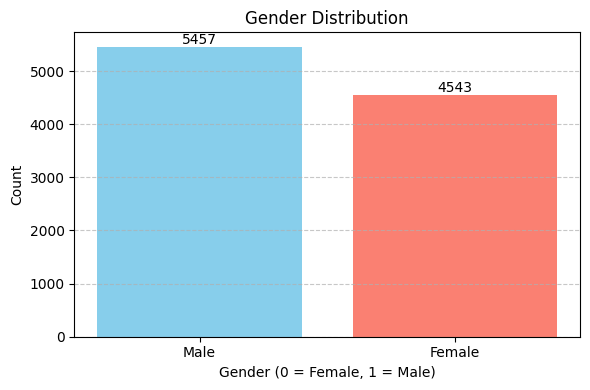

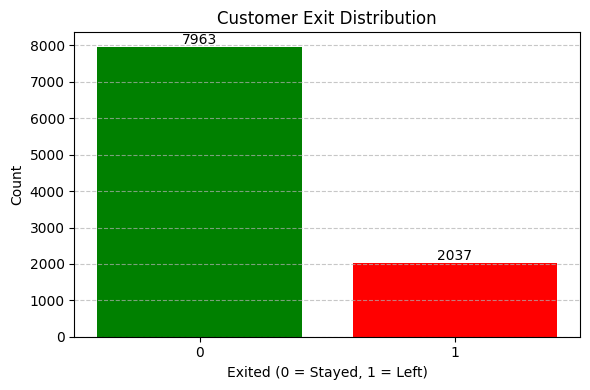

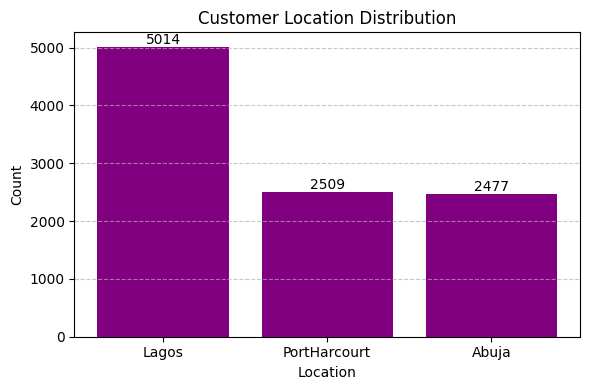

In [12]:
# Chart 1: Gender Distribution
plt.figure(figsize=(6, 4))
bars = plt.bar(gender_dist.index.astype(str), gender_dist.values, color=['skyblue', 'salmon'])
plt.title('Gender Distribution')
plt.xlabel('Gender (0 = Female, 1 = Male)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(bar.get_height()),
             ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

# Chart 2: Exit Distribution
plt.figure(figsize=(6, 4))
bars = plt.bar(exit_dist.index.astype(str), exit_dist.values, color=['green', 'red'])
plt.title('Customer Exit Distribution')
plt.xlabel('Exited (0 = Stayed, 1 = Left)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(bar.get_height()),
             ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

# Chart 3: Location Distribution
plt.figure(figsize=(6, 4))
bars = plt.bar(location_dist.index, location_dist.values, color='purple')
plt.title('Customer Location Distribution')
plt.xlabel('Location')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(bar.get_height()),
             ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

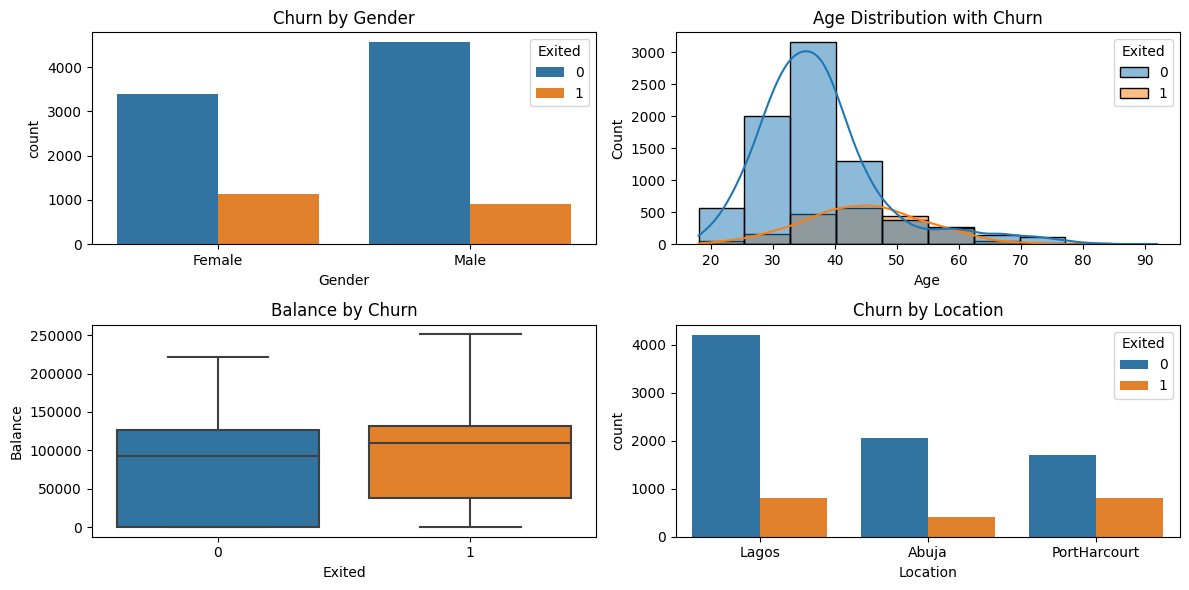

(Gender
 Male      5457
 Female    4543
 Name: count, dtype: int64,
 Exited
 0    7963
 1    2037
 Name: count, dtype: int64,
 Location
 Lagos           5014
 PortHarcourt    2509
 Abuja           2477
 Name: count, dtype: int64)

In [13]:
# Visualizations
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.countplot(data=df, x='Gender', hue='Exited')
plt.title('Churn by Gender')

plt.subplot(2, 2, 2)
sns.histplot(data=df, x='Age', kde=True, bins=10, hue='Exited')
plt.title('Age Distribution with Churn')

plt.subplot(2, 2, 3)
sns.boxplot(data=df, x='Exited', y='Balance')
plt.title('Balance by Churn')

plt.subplot(2, 2, 4)
sns.countplot(data=df, x='Location', hue='Exited')
plt.title('Churn by Location')

plt.tight_layout()
plt.show()

gender_dist, exit_dist, location_dist

        CreditScore           Age        Tenure        Balance  NumOfProducts  \
count  10000.000000  10000.000000  10000.000000   10000.000000   10000.000000   
mean     650.528800     38.921800      5.012800   76485.889288       1.530200   
std       96.653299     10.487806      2.892174   62397.405202       0.581654   
min      350.000000     18.000000      0.000000       0.000000       1.000000   
25%      584.000000     32.000000      3.000000       0.000000       1.000000   
50%      652.000000     37.000000      5.000000   97198.540000       1.000000   
75%      718.000000     44.000000      7.000000  127644.240000       2.000000   
max      850.000000     92.000000     10.000000  250898.090000       4.000000   

         HasDbCard  IsActiveMember  EstimatedSalary  SMSEmailAlert  \
count  10000.00000    10000.000000     10000.000000   10000.000000   
mean       0.70550        0.515100    100090.239881       0.712400   
std        0.45584        0.499797     57510.492818       0.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


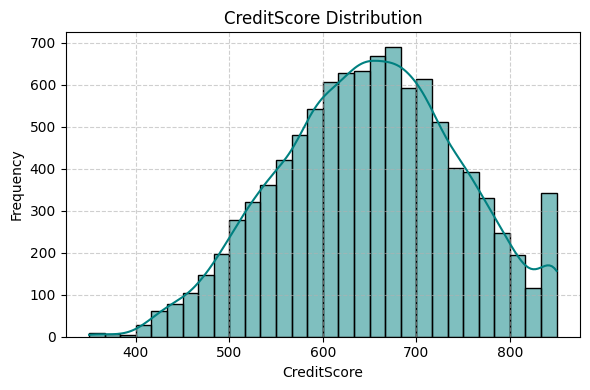

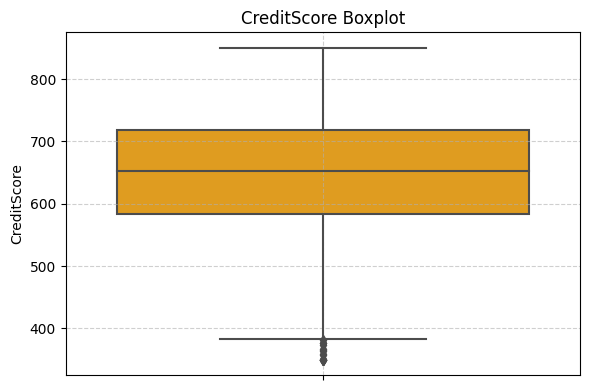

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


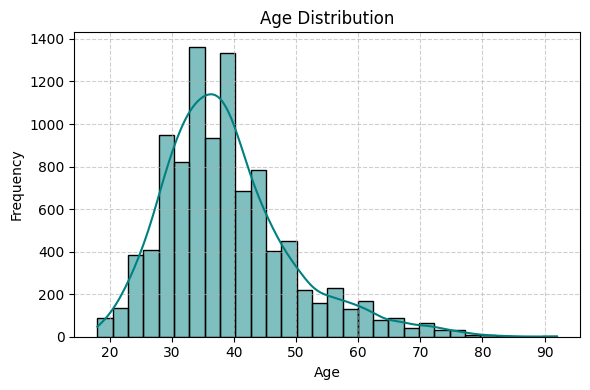

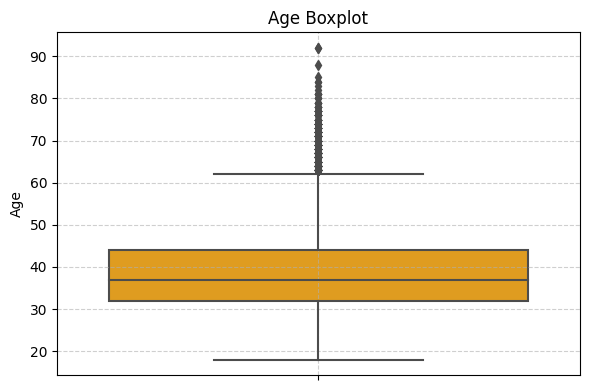

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


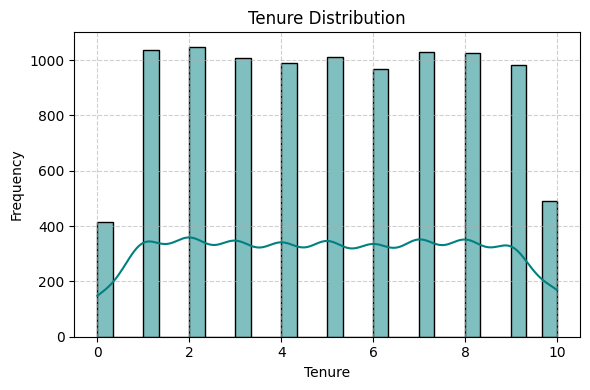

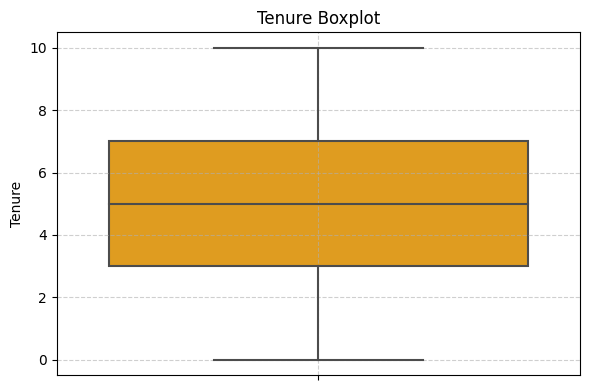

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


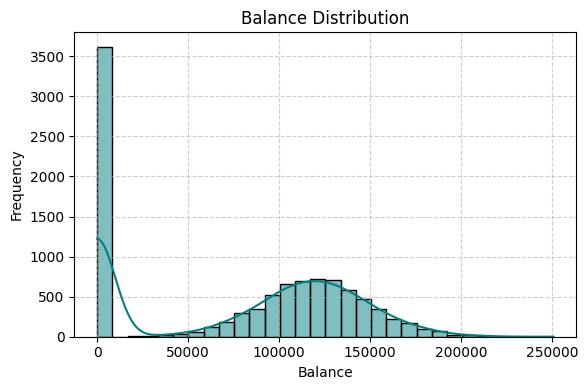

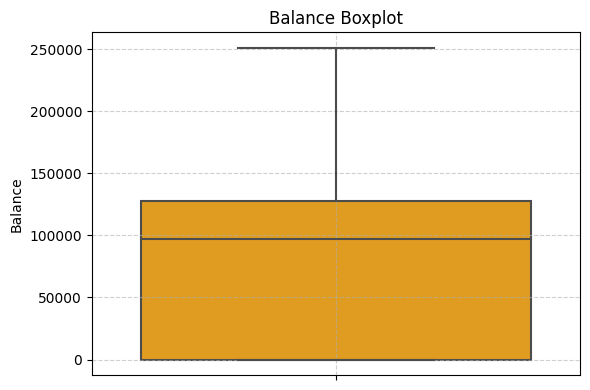

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


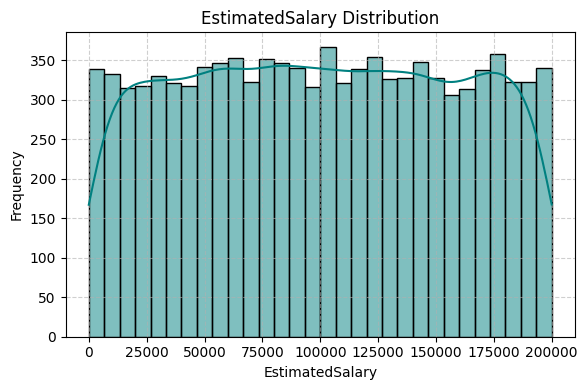

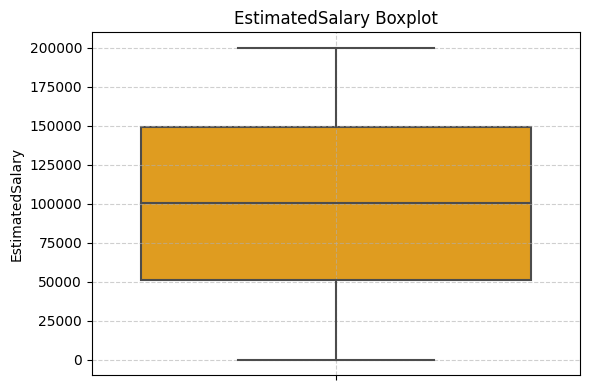

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Descriptive statistics
desc_stats = df.describe()
print(desc_stats)

# Define a function to plot and save histograms
def plot_and_save(column, filename):
    plt.figure(figsize=(6, 4))
    sns.histplot(df[column], kde=True, color='teal', bins=30)
    plt.title(f'{column} Distribution')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(f'{filename}.png')
    plt.show()

# Define a function to plot and save boxplots
def boxplot_and_save(column, filename):
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df[column], color='orange')
    plt.title(f'{column} Boxplot')
    plt.ylabel(column)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(f'{filename}.png')
    plt.show()

# Columns to analyze
columns_to_analyze = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

# Generate and export histogram and boxplot for each column
for col in columns_to_analyze:
    plot_and_save(col, f'{col}_hist')
    boxplot_and_save(col, f'{col}_box')


In [15]:
# Encode categorical variables
df_model = df.copy()
label_encoders = {}
for col in ['Gender', 'Location']:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    label_encoders[col] = le

# Features and target
X = df_model.drop("Exited", axis=1)
y = df_model["Exited"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train models
log_model = LogisticRegression()
tree_model = DecisionTreeClassifier(criterion="gini", random_state=42)
svm_model = SVC(kernel='rbf', probability=True)

log_model.fit(X_train, y_train)
tree_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)

# Predict and evaluate
log_preds = log_model.predict(X_test)
tree_preds = tree_model.predict(X_test)
svm_preds = svm_model.predict(X_test)

log_report = pd.DataFrame(classification_report(y_test, log_preds, output_dict=True)).transpose()
tree_report = pd.DataFrame(classification_report(y_test, tree_preds, output_dict=True)).transpose()
svm_report = pd.DataFrame(classification_report(y_test, svm_preds, output_dict=True)).transpose()

# Display results
print("Logistic Regression Report:\n", log_report)
print("\nDecision Tree Report:\n", tree_report)
print("\nSupport Vector Machine Report:\n", svm_report)

Logistic Regression Report:
               precision    recall  f1-score    support
0              0.870034  0.953951  0.910062  1607.0000
1              0.689076  0.417303  0.519810   393.0000
accuracy       0.848500  0.848500  0.848500     0.8485
macro avg      0.779555  0.685627  0.714936  2000.0000
weighted avg   0.834476  0.848500  0.833378  2000.0000

Decision Tree Report:
               precision    recall  f1-score   support
0              0.890359  0.879278  0.884784  1607.000
1              0.530266  0.557252  0.543424   393.000
accuracy       0.816000  0.816000  0.816000     0.816
macro avg      0.710313  0.718265  0.714104  2000.000
weighted avg   0.819601  0.816000  0.817707  2000.000

Support Vector Machine Report:
               precision    recall  f1-score    support
0              0.894374  0.969508  0.930427  1607.0000
1              0.810078  0.531807  0.642089   393.0000
accuracy       0.883500  0.883500  0.883500     0.8835
macro avg      0.852226  0.750658  0.786

In [16]:
log_report

,precision,recall,f1-score,support
0,0.870034,0.953951,0.910062,1607.0000
1,0.689076,0.417303,0.519810,393.0000
accuracy,0.848500,0.848500,0.848500,0.8485
macro avg,0.779555,0.685627,0.714936,2000.0000
weighted avg,0.834476,0.848500,0.833378,2000.0000


In [17]:
tree_report

,precision,recall,f1-score,support
0,0.890359,0.879278,0.884784,1607.000
1,0.530266,0.557252,0.543424,393.000
accuracy,0.816000,0.816000,0.816000,0.816
macro avg,0.710313,0.718265,0.714104,2000.000
weighted avg,0.819601,0.816000,0.817707,2000.000


In [18]:
svm_report

,precision,recall,f1-score,support
0,0.894374,0.969508,0.930427,1607.0000
1,0.810078,0.531807,0.642089,393.0000
accuracy,0.883500,0.883500,0.883500,0.8835
macro avg,0.852226,0.750658,0.786258,2000.0000
weighted avg,0.877810,0.883500,0.873769,2000.0000


In [19]:
# Feature importance from logistic regression
feature_names = X.columns
coefficients = log_model.coef_[0]
log_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Impact': ['Positive' if coef > 0 else 'Negative' for coef in coefficients],
    'Absolute Coef': np.abs(coefficients)
}).sort_values(by='Absolute Coef', ascending=False)

print(log_importance)

            Feature  Coefficient    Impact  Absolute Coef
10    SMSEmailAlert    -0.869165  Negative       0.869165
3               Age     0.764510  Positive       0.764510
8    IsActiveMember    -0.515688  Negative       0.515688
2            Gender    -0.255185  Negative       0.255185
1          Location     0.229745  Positive       0.229745
5           Balance     0.213364  Positive       0.213364
4            Tenure    -0.057557  Negative       0.057557
6     NumOfProducts    -0.048584  Negative       0.048584
0       CreditScore    -0.045524  Negative       0.045524
9   EstimatedSalary     0.014137  Positive       0.014137
7         HasDbCard    -0.001791  Negative       0.001791


In [20]:
# Feature importance from decision tree
tree_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': tree_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(tree_importance)

            Feature  Importance
3               Age    0.192730
10    SMSEmailAlert    0.149378
9   EstimatedSalary    0.139424
5           Balance    0.131208
0       CreditScore    0.117452
6     NumOfProducts    0.094592
4            Tenure    0.059777
8    IsActiveMember    0.049347
1          Location    0.036676
2            Gender    0.015604
7         HasDbCard    0.013813


In [21]:
from sklearn.inspection import permutation_importance

svm_result = permutation_importance(svm_model, X_test, y_test, n_repeats=10, random_state=42)

svm_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance Mean': svm_result.importances_mean,
    'Importance Std': svm_result.importances_std
}).sort_values(by='Importance Mean', ascending=False)

print(svm_importance)

            Feature  Importance Mean  Importance Std
3               Age          0.05980        0.006914
6     NumOfProducts          0.05965        0.003668
10    SMSEmailAlert          0.03890        0.002844
8    IsActiveMember          0.02900        0.004099
1          Location          0.01370        0.003027
5           Balance          0.00650        0.001949
2            Gender          0.00275        0.002016
0       CreditScore          0.00140        0.001338
9   EstimatedSalary          0.00125        0.002171
4            Tenure          0.00055        0.001524
7         HasDbCard         -0.00040        0.001828
